In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Interactive Instance Segmentation using SAM 3

Segment Anything Model 3 (SAM 3) predicts instance masks that indicate the desired object given geometric prompts (SAM 1 task).
The `SAM3Image` and `Sam3Processor` classes provide an easy interface to prompt the model. The user first sets an image using the `Sam3Processor.set_image` method, which computes the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

This notebook follows the SAM 2 API for interactive image segmentation.

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_for_sam1_task_example.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>


## Environment Set-up

First install `sam3` in your environment using the [installation instructions](https://github.com/facebookresearch/sam3?tab=readme-ov-file#installation) in the repository.

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
using_colab = False

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import sam3
sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")


C:\Users\rebel\sam3\sam3\model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 3 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [4]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

## Example image

In [5]:
image = Image.open(f"{sam3_root}/assets/images/truck.jpg")

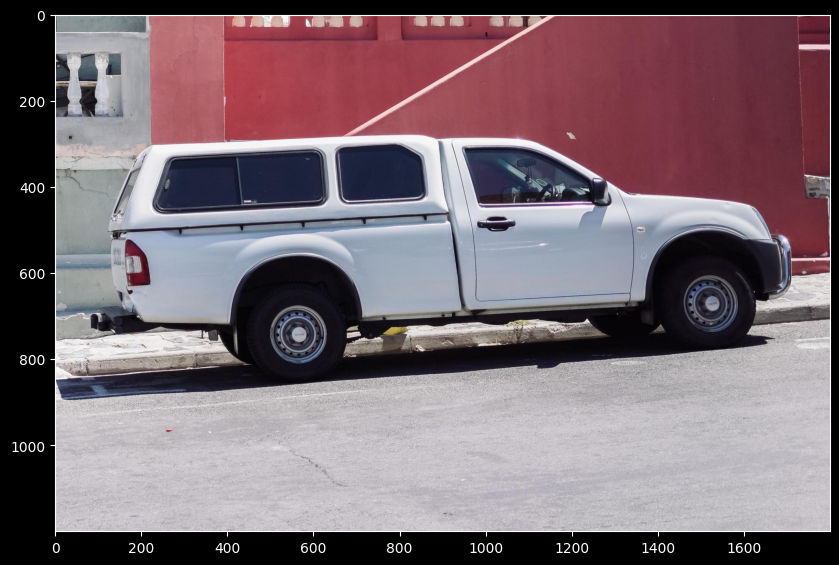

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM 3

First, load the SAM 3 model. Running on CUDA and using the default model are recommended for best results.

In [7]:

from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path, enable_inst_interactivity=True)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rebel\\sam3\\assets\\bpe_simple_vocab_16e6.txt.gz'

Process the image to produce an image embedding by calling `Sam3Processor.set_image`.

In [ ]:
processor = Sam3Processor(model)
inference_state = processor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [ ]:
input_point = np.array([[520, 375]])
input_label = np.array([1])

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SAM3Image.predict_inst`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
masks, scores, logits = model.predict_inst(
    inference_state,
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

With `multimask_output=True` (the default setting), SAM 3 outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [ ]:
masks.shape  # (number_of_masks) x H x W

In [ ]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, scores, _ = model.predict_inst(
    inference_state,
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
masks.shape

In [ ]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, scores, _ = model.predict_inst(
    inference_state,
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [ ]:
input_box = np.array([425, 600, 700, 875])

In [ ]:
masks, scores, _ = model.predict_inst(
    inference_state,
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [ ]:
show_masks(image, masks, scores, box_coords=input_box)

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [ ]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [ ]:
masks, scores, logits = model.predict_inst(
    inference_state,
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

In [ ]:
show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)

## Batched prompt inputs

`SAM3Image` can take multiple input prompts for the same image, using `predict_inst` method. For example, imagine we have several box outputs from an object detector.

In [ ]:
input_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

In [ ]:
masks, scores, _ = model.predict_inst(
    inference_state,
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

In [ ]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

## End-to-end batched inference
If all prompts are available in advance, it is possible to run SAM 3 directly in an end-to-end fashion. This also allows batching over images.

In [ ]:
image1 = image  # truck.jpg from above
image1_boxes = np.array([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
])

image2 = Image.open(f"{sam3_root}/assets/images/groceries.jpg")
image2_boxes = np.array([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
])

img_batch = [image1, image2]
boxes_batch = [image1_boxes, image2_boxes]

In [ ]:
inference_state = processor.set_image_batch(img_batch)

In [ ]:
masks_batch, scores_batch, _ = model.predict_inst_batch(
    inference_state,
    None,
    None, 
    box_batch=boxes_batch, 
    multimask_output=False
)

In [ ]:
for image, boxes, masks in zip(img_batch, boxes_batch, masks_batch):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)   
    for mask in masks:
        show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    for box in boxes:
        show_box(box, plt.gca())

Similarly, we can have a batch of point prompts defined over a batch of images

In [ ]:
image1 = image  # truck.jpg from above
image1_pts = np.array([
    [[500, 375]],
    [[650, 750]]
    ]) # Bx1x2 where B corresponds to number of objects 
image1_labels = np.array([[1], [1]])

image2_pts = np.array([
    [[400, 300]],
    [[630, 300]],
])
image2_labels = np.array([[1], [1]])

pts_batch = [image1_pts, image2_pts]
labels_batch = [image1_labels, image2_labels]

In [ ]:
masks_batch, scores_batch, _ = model.predict_inst_batch(inference_state, pts_batch, labels_batch, box_batch=None, multimask_output=True)

# Select the best single mask per object
best_masks = []
for masks, scores in zip(masks_batch,scores_batch):
    best_masks.append(masks[range(len(masks)), np.argmax(scores, axis=-1)])

In [ ]:
for image, points, labels, masks in zip(img_batch, pts_batch, labels_batch, best_masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)   
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    show_points(points, labels, plt.gca())